<a href="https://colab.research.google.com/github/rezaahmadi-99/statistical-arbitrage-RL/blob/main/Advanced_Statistical_Arbitrage_with_Reinforcement_Learning_Implementation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import zscore
import matplotlib.pyplot as plt
import seaborn as sns

# **Stochastic Process(Ornstein-Uhlenbeck)**

Ornestein-Uhlenbeck process is a stochastic process with 3 parameters:  $μ$(mean), $θ$(speed of reversion) and $σ$(volatility).

Ornstein-Uhlenbeck is commonly used for statistical arbitrage strategy where the relationship is stationary and two assets are highly cointegrated, which fits the this mean-reversion strategy very well.

The stochastic differential equation (SDE) for the Ornstein-Uhlenbeck process is:

$$dX_t = \theta (\mu - X_t)\, dt + \sigma \, dW_t$$

In Itô calculus, the Euler–Maruyama method (also simply called the Euler method) is a method for the approximate numerical solution of a stochastic differential equation (SDE). The discretized update at each step is:

$$X_{t+\Delta t} = X_t + \theta(\mu - X_t)\Delta t + \sigma\sqrt{\Delta t} \cdot Z$$

$$\text{where } Z \sim \text{Normal(0,1)}$$

The discretized update is useful for generating paths of OU process.

**OU Process Function:**

Function **OU_simulation** is constructed to generate simulations of OU process.

In [2]:
def OU_simulation(mu, theta, sigma, delta_time, n_sims, T, random_state):

  simulations = np.zeros((n_sims, T))

  for sim in range(n_sims):

    # choose a random start point from gaussian distribution with OU process' sigma as its standard deviation
    x_0 = random_state.normal(loc=theta, scale=sigma)

    # looping through each simulation
    for t in range(T):
      simulations[sim, t] = x_0
      diffusion_contribution = sigma * np.sqrt(delta_time) * random_state.randn()
      drift_contribution = mu * (theta - x_0) * delta_time
      x = x_0 + drift_contribution + diffusion_contribution
      x_0 = x
  return simulations

# **Cointegration (Optimal $B$ Coefficient)**

Cointegration occurs when two or more non-stationary time series move together in such a way that their linear combination becomes stationary.

The linear combination which is called spread, comes from the formula:
$$X = ∑_{i=1}^{n}a_i S_i$$

The spread formula for cointegration between 2 instruments becomes:
$$X = S_1 - BS_2$$

A traditional method for finding the optimal value for coefficient $B$ is maximum liklihood estimate (MLE). However, the authors find the optimal value through empirical study. Specifically, they implement the algorithm from a paper published in 2007 named:


 "*Fink, Eugene, and Harith Suman Gandhi. "Important extrema of time series." (2007).*"


In the paper, authors create an algorithm that is capable of finding extrema points in a time series data. In the algorithm, there is a positive parameter named $R$, which adjusts the compression rate. The larger the value of $R$ parameter, the fewer important extrema are selected.

The authors in paper:
$$$$

*Ning, Boming, and Kiseop Lee. "Advanced statistical arbitrage with reinforcement learning." International Journal of Financial Engineering 12, no. 04 (2025): 2550019.*

$$$$
use the algorithm from the previous paper to find extrema points in the time series. The goal is to find a $B$ value that minimizes the average time that it takes for the spread to reach its long-term mean from extrema. Since the approach is empirical, a set of potential $B$ values are passed to a grid search algorithm to find the average reversion time ($r$) and choose the $B$ coefficient with the smallest $r$.

The optimal coefficient $B$ is computed on **formation phase** (2023-01-01 to 2023-12-31) and is used on **trading phase** (2024-01-01 to 2024-12-31).

This section focuses on finding the optimal $B$ coefficient for cointegration between tickers **GOOGL** and **MSFT**.

**Composing Algorithm for Finding Important Extrema**

Code reproduction of the algorithm is implemented from paper below:

*Fink, Eugene, and Harith Suman Gandhi. "Important extrema of time series." (2007).*

There are various distance functions to compute distance between points which are briefly mentioned in the paper. However, simple $\left|y_i - y_j\right|$ is chosen for this project.

In [3]:
def dist(a1, a2):
  return abs(a1 - a2)

def find_first():
  i, left_min, right_min, left_max, right_max = 1, 1, 1, 1, 1
  while (i < n and dist(a[i+1], a[left_max]) < R and dist(a[i+1], a[left_min]) < R):
    if(a[left_min] > a[i]):
      left_min = i
    if(a[right_min] >= a[i]):
      right_min = i
    if(a[left_max] < a[i]):
      left_max = i
    if(a[right_max] <= a[i]):
      right_max = i
    i += 1
  i += 1
  if(i < n and a[i] > a[1]):
    output_ext(left_min, right_min, "min")
  if(i < n and a[i] < a[1]):
    output_ext(left_max, right_max, "max")
  return i

def find_min(i):
  left = i; right = i
  while (i < n and (a[i+1] < a[left] or dist(a[i+1], a[left]) < R)):
    if (a[left] > a[i]):
      left = i
    if (a[right] >= a[i]):
      right = i
    i += 1
  output_ext(left, right, "min")
  return i + 1

def find_max(i):
  left = i; right = i
  while (i < n and (a[i+1] > a[left] or dist(a[i+1], a[left]) < R)):
    if (a[left] < a[i]):
      left = i
    if (a[right] <= a[i]):
      right = i
    i += 1
  output_ext(left, right, "max")
  return i + 1

def output_ext(left, right, min_or_max):
  if left == right:
    # print(f"({a[right], right, min_or_max}, strict)")
    key_val[right] = a[right].item()
    extrema_type.append(min_or_max)
  else:
    # print(f"({a[left], left, min_or_max}, left)")
    key_val[left] = a[left].item()
    extrema_type.append(min_or_max)

    for flat in range(left+1, right-1):
      if a[flat] == a[left]:
        # print(f"({a[flat], flat, min_or_max}, flat)")
        key_val[flat] = a[flat].item()
        extrema_type.append(min_or_max)

    # print(f"({a[right], right, min_or_max}, right)")
    key_val[right] = a[right].item()
    extrema_type.append(min_or_max)

**About $R$:**

$R$ is a parameter from Fink and Gandhi's paper which determines the compression rate, that is, how much further each point should be from other parts of the data to be considered an extremum. An increase of $R$ leads to the selection of fewer important extrema. The default value in the paper is 3. However, it must be adjusted based on data.

As far as $T$, Ning and Lee choose 252 as there are 252 trading days for each instrument annually.

In [4]:
R = 0.4

# Theta is the long-term mean, mu is the reversion speed, sigma is the deviation term
mu = 0.4; theta = 1; sigma = 0.1; delta_time = 1; n_sims = 1; T = 252; rng = np.random.RandomState(947)

a = OU_simulation(mu = mu, theta = theta, sigma = sigma, delta_time = delta_time, n_sims = n_sims, T = T, random_state=rng)[0]

n = len(a) - 1

# in order to keep indices within the correct range to avoid errors, Nan is added to the beginning of the time-series data
a = np.insert(a, 0, np.nan)

key_val = dict()
extrema_type = []

i = find_first()
if (i < n  and a[i] < a[1]):
  i = find_min(i)
while i < n:
  i = find_max(i)
  i = find_min(i)

# sometimes the last value in the series is wrongly chosen as an extrema
# to avoid it the extrema in the last time step is removed if it exists
if n-1 in key_val:
  key_val.pop(n-1)

**Illustration of extrema**

Number of extrema: 13


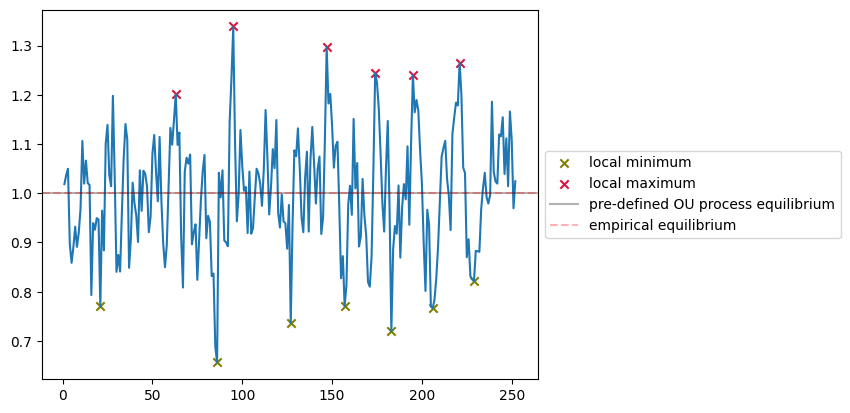

In [5]:
fig, ax = plt.subplots()

for i, color in enumerate(['olive', 'crimson']):
  ax.scatter(list(key_val.keys())[i::2],
             list(key_val.values())[i::2],
             label='local minimum' if extrema_type[i] == 'min' else 'local maximum',
             marker='x', color=color)


ax.plot(a)
ax.axhline(theta, color='black', alpha=0.3, label='pre-defined OU process equilibrium')
# average of a[1:] is computed for empirical equilibrium since the first value is NaN
ax.axhline(np.mean(a[1:]), color='red', linestyle='--', alpha=0.3, label='empirical equilibrium')
print(f"Number of extrema: {len(key_val)}")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**About empirical mean reversion time:**

In paper

 *Ning, Boming, and Kiseop Lee. "Advanced Statistical Arbitrage with Reinforcement Learning." arXiv preprint arXiv:2403.12180 (2024).*

 the average mean reversion time dictates the coefficient(s) of spread when choosing 2 or more instruments.

**first_cross_idx** stores the first index that crosses the mean after each extremum. Then by using **extrema_idx**, the average mean reversion time is computed from each extremum to the first index where the value crosses the mean.

In [6]:
extrema_idx = list(key_val.keys())
# since NaN is inserted to the first index
a_mean = np.mean(a[1:])
first_cross_idx = []

for id in extrema_idx:

  # find the sign of the (extrema - theta), find when the sign changes
  sign = np.sign(a[id] - a_mean)
  start_id = id
  while True:
    start_id += 1
    if np.sign(a[start_id] - a_mean) != sign:
      first_cross_idx.append(start_id)
      break
    if start_id == len(a) - 1:
      print('done')
      break

compute average mean reversion time

In [7]:
mean_reversion_time = np.sum(abs(np.array(extrema_idx) - np.array(first_cross_idx))) / len(extrema_idx)
print(f"The average mean reversion time for the simulation is: {round(mean_reversion_time, 2)}")

The average mean reversion time for the simulation is: 3.77


**Extrema and first points that cross the mean**

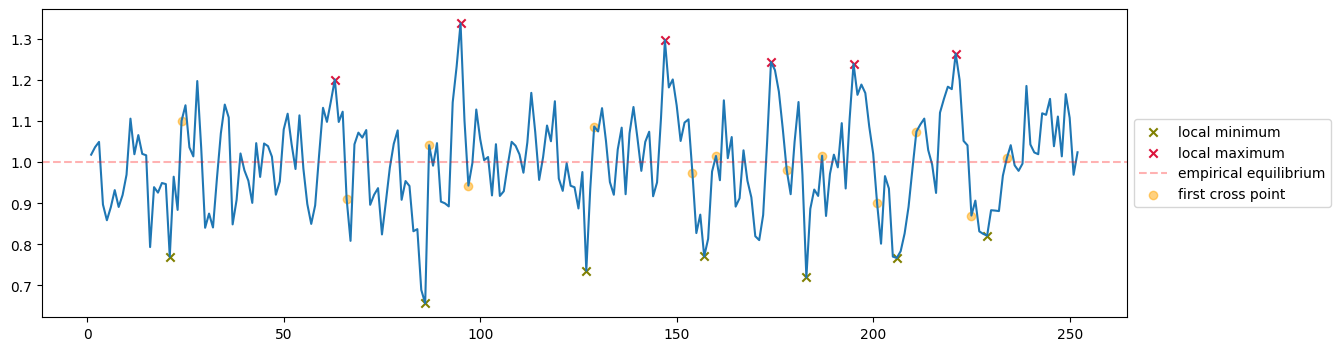

In [8]:
fig, ax = plt.subplots(figsize=(14, 4))

for i, color in enumerate(['olive', 'crimson']):
  ax.scatter(list(key_val.keys())[i::2],
             list(key_val.values())[i::2],
             label='local minimum' if extrema_type[i] == 'min' else 'local maximum',
             marker='x', color=color)


ax.plot(a)
# average of a[1:] is computed for empirical equilibrium since the first value is NaN
ax.axhline(np.mean(a[1:]), color='red', linestyle='--', alpha=0.3, label='empirical equilibrium')
ax.scatter(first_cross_idx, a[first_cross_idx], color='orange', alpha=0.5, label='first cross point')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()

**Important extrema finder class:**

To create a smoother way to compute the mean reversion time, a class named **ImportantExtremaFinder** is constructed in order to find extrema, before finding the first cross points and subsequently the computing mean reversion time.

**Some important notes to consider regarding the algorithm:**

It is crucial to understand where the algorithm works and where it fails. In the paper, authors mention $𝜏_n$ which stores the values for extrema and the first point that crosses the mean in a way that all odd-numbered time moments ($𝜏_1$, $𝜏_3$, $𝜏_5$,...) are extrema and all even-numbered time moments ($𝜏_2$, $𝜏_4$, $𝜏_6$,...) are all corssing points. However if the data is non-stationary, the algorithm is likely to find far more extrema than crossing points. This leads to the creation of **is_stationary** mehtod as a prerequisite for **mean_reversion time** method. It evaluates whether extrema are repeated above and below the mean every other time in extrema list. This logic ensures that every other extremum is either above or below the mean which yields the same length (or at most one discrepancy) for both the number of exterma and the number of crossing points. If **mean_reversion_time** is called on non-stationary data, the algorithm will throw out an error, pointing out the inequality in the number of extrema and crossing points.

It is also essential to mention that there are times when after an extremum the data runs out before reaching the mean. A condition is created in **mean_reversion_time** method to account for this.

In [9]:
class ImportantExtremaFinder:

  def __init__(self, a, R) -> None:
    self.key_val = dict()
    self.extrema_type = []
    self.a = list(a)
    self.n = len(self.a) - 1
    self.a = np.insert(self.a, 0, np.nan)
    self.R = R

  def dist(self, a1, a2):
    return abs(a1 - a2)

  def find_first(self):
    i, self.left_min, self.right_min, self.left_max, self.right_max = 1, 1, 1, 1, 1
    while (i < self.n and self.dist(self.a[i+1], self.a[self.left_max]) < self.R and self.dist(self.a[i+1], self.a[self.left_min]) < self.R):
      if(self.a[self.left_min] > self.a[i]):
        self.left_min = i
      if(self.a[self.right_min] >= self.a[i]):
        self.right_min = i
      if(self.a[self.left_max] < self.a[i]):
        self.left_max = i
      if(self.a[self.right_max] <= self.a[i]):
        self.right_max = i
      i += 1
    i += 1
    if(i < self.n and self.a[i] > self.a[1]):
      self.output_ext(self.left_min, self.right_min, "min")
    if(i < self.n and self.a[i] < self.a[1]):
      self.output_ext(self.left_max, self.right_max, "max")
    return i

  def find_min(self, i):
    left = i; right = i
    while (i < self.n and (self.a[i+1] < self.a[left] or self.dist(self.a[i+1], self.a[left]) < self.R)):
      if (self.a[left] > self.a[i]):
        left = i
      if (self.a[right] >= self.a[i]):
        right = i
      i += 1
    self.output_ext(left, right, "min")
    return i + 1

  def find_max(self, i):
    left = i; right = i
    while (i < self.n and (self.a[i+1] > self.a[left] or self.dist(self.a[i+1], self.a[left]) < self.R)):
      if (self.a[left] < self.a[i]):
        left = i
      if (self.a[right] <= self.a[i]):
        right = i
      i += 1
    self.output_ext(left, right, "max")
    return i + 1

  def output_ext(self, left, right, min_or_max):
    if left == right:
      self.key_val[right-1] = self.a[right].item()
      self.extrema_type.append(min_or_max)
    else:
      self.key_val[left-1] = self.a[left].item()
      self.extrema_type.append(min_or_max)

      for flat in range(left+1, right-1):
        if self.a[flat] == self.a[left]:
          self.key_val[flat-1] = self.a[flat].item()
          self.extrema_type.append(min_or_max)

      self.key_val[right-1] = self.a[right].item()
      self.extrema_type.append(min_or_max)

  def extrema_dict(self):

    i = self.find_first()
    if (i < self.n  and self.a[i] < self.a[1]):
      i = self.find_min(i)
    while i < self.n:
      i = self.find_max(i)
      i = self.find_min(i)

    # sometimes the last value in the series is wrongly chosen as an extrema
    # to avoid it the extrema in the last time step is removed if it exists
    if self.n-1 in self.key_val:
      self.key_val.pop(self.n-1)

    return self.key_val

  def is_stationary(self):

    # since NaN is inserted to the first index
    self.a_mean = np.mean(self.a[1:])

    # Ensuring every other element is above or below the mean
    # if it is the case, the data is suitable for computing mean reversion time
    # otherwise it is not
    above_below = np.array(list(self.key_val.values())) > self.a_mean
    if (len(set(above_below[::2])) == 1 and len(set(above_below[1::2])) == 1):
      return True
    else:
      return False

  def mean_reversion_time(self):
    self.extrema_idx = list(self.key_val.keys())

    self.first_cross_idx = []

    for id in self.extrema_idx:

      # find the sign of the (extrema - theta), find when the sign changes
      sign = np.sign(self.a[id] - self.a_mean)

      start_id = id

      while True:
        start_id += 1
        if np.sign(self.a[start_id] - self.a_mean) != sign:
          self.first_cross_idx.append(start_id)
          break
        if start_id == len(self.a) - 1:
          break

    # there are times when after the last extremum, data finishes before crossing the mean which
    # causes the cross points to have 1 element fewer than the number of extrema. When this happens, the last extremum
    # is trimmed off to keep the same length for computing mean reversion time

    extrema_idx_copy = self.extrema_idx
    if len(self.extrema_idx) != len(self.first_cross_idx):
      extrema_idx_copy.pop()

    mean_reversion_time = np.sum(abs(np.array(extrema_idx_copy) - np.array(self.first_cross_idx))) / len(self.extrema_idx)

    return mean_reversion_time

**Grid search:**

In the paper, the authors use grid search algorithm to find the optimal coefficient $B$, to create a spread with the least mean reversion time from extrema to mean.

**Choosing $R$ value:**

Through tests of various stationary data, the value of $R$ (compression rate) will be **2** times the value of the standard deviation of the data. Through tirals, this value seems to be appropriate.

In [10]:
dat = yf.Tickers('GOOGL MSFT')
a = dat.tickers['GOOGL'].history(start='2023-01-01', end='2023-12-31')
b = dat.tickers['MSFT'].history(start='2023-01-01', end='2023-12-31')

a_norm = zscore(a['Close'])
b_norm = zscore(b['Close'])

**Finding the optimal coefficient $B$ for cointergration:**

The cell below conducts a grid search algorithm to find the optimal value for $B$ for cointegration between Microdoft and Google.

Similar to the paper, the chosen range for $B$ coefficient is $B ∈ \{-3, -2.99, -2.98, ..., 2.98, 2.99\}$ which contains 600 potential values to choose the optimal $B$ value.

In [11]:
B_list = np.round(np.arange(-3, 3, 0.01), 2)
r_time_dict = dict()
for B in B_list:

  X = a_norm - B.item() * b_norm

  # adjusting R
  R = np.std(X) * 2

  instantiated = ImportantExtremaFinder(X, R= 2 * np.std(X))
  k_v = instantiated.extrema_dict()

  # is data suitable for the algorithm?
  if instantiated.is_stationary():
    # likely stationary
    r = instantiated.mean_reversion_time()
    r_time_dict[B.item()] = r
  else:
    # not suitable (likely non-stationary)
    # set infinity to the mean reversion time so we can selected the
    # smallest mean reversion time and its key (which is coefficient)
    r_time_dict[B.item()] = np.inf

# optimal B value
googl_msft_B = min(r_time_dict, key=r_time_dict.get)

In [12]:
print(f"Optimal value for coefficient B is: {googl_msft_B}")

Optimal value for coefficient B is: 0.73


# **Reinforcement Learning ($Q$-learning)**

This section focuses on creating an agent that is adept in a stationary environment. For this project, similar to the paper, $Q$-learning algorithm is utilized to train the agent.

The goal is to create a $Q$-table that stores a $Q$-value for each possible action in each state. Similar to the paper, the state is an array with 4 features:
$$$$
Discretized spread change in the last 4 time steps
$$$$

Since $Q$-table is holds finite values, it is crucial to discretize spread change percentages. The paper uses a threshold $k = 0.03$ to change each spread change percentage to one of these values:

$$d_i =
\begin{cases}
+2 & \text{if } \pi_i > k, \\
+1 & \text{if } 0 < \pi_i < k, \\
-1 & \text{if } -k < \pi_i < 0, \\
-2 & \text{if } \pi_i < -k.
\end{cases}$$

This ensure there are finite number of unique states in the environment. Precisely, there are 256 unique states in the environment. Since there are possible 3 actions (buy, hold and sell), each of the states must store 3 values each representing the $Q$-value for each action.
$$$$

For training the agent, 10,000 simulations of Ornstein-Uhlenbeck process with fixed parameters is generated. This number of simulations can ensure each state is reapted sufficiently to find the optimal action at each state.

$$$$
The actions that the agent can take in training and testing is constrained by its position at each time. If the agent's position is 0 (does not have an open position), it cannot choose the "sell" action. If the agent's position is 1 (open position), it cannot choose the "buy" action. This constrain which is mentioned in the paper prevents the agent from shorting or stacking multiple buy or sell actions which can lead to large positions that can lead to large drawdowns.



**Defining the same reward function from Ning and Lee paper**

In [13]:
def reward_function(action, mean, spread, transaction_fee=0.005):
  reward = action * (mean - spread) - transaction_fee * abs(action)
  return reward.item()

**Transform raw data into states:**

The authors in the paper transformed the raw spread data by computing the percentage change of spread at time $t$ compared to time $t -1$. This percentage change is important as it implicitly normalizes the raw spread value.

Authors categorized spread changes into 4 distinct values: $\{-2, -1, 1, 2\}$. They use a threshold parameter $k$, to categorize price changes. In the paper, this parameter was set to 3\% which will be repeated in this implementation.

Function **create_states** is very useful as it computes the state equivalent of each raw spread value at each time. The function is particularly helpful since it can compute the states representation of the simulation in training phase and the stream of data in testing phase. Even though the number of spread percentage changes of $N$ data is $N - 1$, this function creates $N$ state representations.

It is important to note that the function only accepts data stream with length of 2 and more. The state representation for the first data must be assigned independently.

In [14]:
def create_states(spread, lookback_len, k=0.03):

  spread_changes = []
  for i in range(1, len(spread)):
    change = (spread[i] - spread[i-1]) / (abs(spread[i-1]) + 1e-8) * 100

    # Identical to Ning and Lee paper, state space is discretized
    if change >= k:
      change = 2
    elif (change >= 0 and change < k):
      change = 1
    elif change <= -k:
      change = -2
    elif change < 0 and change > -k:
      change = -1

    # store changes
    spread_changes.append(change)

  window_zeros = np.ones(lookback_len)

  # concatenate 0 values to the beginning of spread changes since there is a
  # look back window
  concat_vals = np.concat((window_zeros, spread_changes))
  changes_window = np.lib.stride_tricks.sliding_window_view(concat_vals, window_shape=lookback_len)

  return changes_window

**Constraint of Actions:**

The paper explicitly indicates the essence of providing what action can be taken based on the position size. If no position is held, we can either continue not holding a position or go long. On the other hand, if the position size is 1 (already long), we can either sell the position that we have or continue holding it.

if a random action is chosen, we eliminate the invalid action from the list of actions ($[-1, 0, 1]$), and if the greedy approach is chosen, then the $Q$-value of the invalid action is set to $-∞$ to ensure it will not be chosen.

In [15]:
class ConstrainAction:
  def __init__(self):
    self.position = 0

  def for_random_actions(self):
    if self.position == 0:
      valid_actions = [0, 1]
    elif self.position == 1:
      valid_actions = [-1, 0]

    return valid_actions

  def for_greedy_Q(self, Q_values):
    if self.position == 0:
      Q_values[0] = - float('inf')
    elif self.position == 1:
      Q_values[2] = - float('inf')

    return Q_values

**Monitoring Progression:**

In the foundational paper:

*Mnih, Volodymyr. "Playing atari with deep reinforcement learning." arXiv preprint arXiv:1312.5602 (2013).*

 authors note that instead of using average reward in each episode which leads to noisy values, it is better to track the average $Q$-value of the chosen actions in each episode. For that reason, **$Q$_state_action_value** function is created to return the $Q$-value of chosen action at each step.

In [16]:
def Q_state_action_value(state_in_Q_table, action):

  # transform action to find the Q-value of the chosen action
  if action == -1:
    action = 0
  elif action == 0:
    action = 1
  elif action == 1:
    action = 2

  chosen_Q_value = Q_table[state_in_Q_table][action]

  return chosen_Q_value.item()

**Creating $Q$-table:**

Based on the Ning and Lee paper, the look back window is 4, meaning the last 4 spread change percentages are features of the environment. Also there 4 possible states in each trajectory $[-2, -1, 1, 2]$. The number of all possible states will have the length of $d^l$, where $d$ is the number of possible spread change percentages and $l$ is the look back length. As aresult, The $Q$-table will have 256 unique states. Each state must store $Q$-value for each action, so that the action with the highest $Q$ can be chosen in testing phase.

In [17]:
# index 0: -> spread change category: -2
# index 1: -> spread change category: -1
# index 2: -> spread change category:  1
# index 3: -> spread change category:  2
Q_table = np.zeros((4, 4, 4, 4, 3))

**Finding the place of each state in $Q$-table:**

Function **state_in_Q_table** is created to receive the state from the environment and find its place in $Q$-table.

In [18]:
def find_state_in_Q_table(state):

  transformed_state = []
  # -2 spread change is set to 0 index
  # -1 spread change is set to 1 index
  #  1 spread change is set to 2 index
  #  2 spread change is set to 3 index

  for feature in range(len(state)):
    if state[feature] == -2:
      transformed_state.append(0)
    elif state[feature] == -1:
      transformed_state.append(1)
    elif state[feature] == 1:
      transformed_state.append(2)
    elif state[feature] == 2:
      transformed_state.append(3)

  # Tuple is returned so that the place of the state
  # in Q_table can be found with ease
  return tuple(transformed_state)

**Using visualization for tracking how $ϵ$ anneals:**

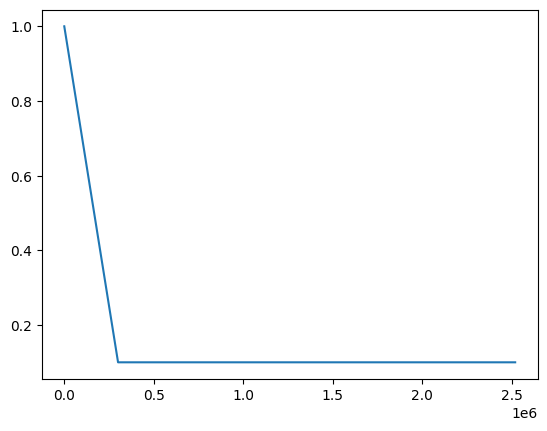

In [19]:
e = 1
e_list = []

for i in range(2520000):
  e = max(e - 3e-6, 0.10)
  e_list.append(e)

plt.plot(e_list)
plt.show()

**$Q$-Learning:**

In Q-learning with Q-table, the goal is to set correct $Q$-values to each action of each unique state. **10,000** Ornstein-Uhlenbeck process paths will be generated to implement $Q$-learning algorithm. In each state of each episode, $Q$-table will be updated. This training will create an adpet $Q$-table that stores the $Q$-value for every possible action in each of the possible finite state.

In [20]:
# initialize Q-table
Q_table = np.zeros((4, 4, 4, 4, 3))

episodes = 10000
# trajectory length in each episode
T = 252

# look back window is set to 4, same as the paper
lookback_window = 4

# probability of selecting a random action
epsilon = 1

# decay rate for linear annealing
epsilon_decay_rate = 3e-6

# the same value in the paper will be repeated in this study
min_exploration = 0.1

# Discount factor (shown as gamma sign) which controls how much agent values
# future rewards
gamma = 0.99

# Learning rate determines how aggressively the parameters of the network change
learning_rate = 0.01

# The paper indicates limiting actions based on the current position
constrain_actions = ConstrainAction()

# setting a constant long-term mean value for each OU process simulation
theta = 10

# similar to the Ning and Lee paper, k threshold determines which category
# each spread change percantage is assigned to
k = 0.03

# Creating a seed for reproduction
rng = np.random.RandomState(2026)

# For logging (to monitor the learning of agent):

# list to store Q values of each episode
episode_Q_values_list = []
# average Q over episode list for progression tracking
average_episode_Q_values_list = []

# also, there will be a list to store the sum of buy and sell actions
# in each episode
sum_buy_sell_list = []

for episode in range(episodes):
  # simulate OU process
  sim_data = OU_simulation(mu=1, theta=theta, sigma=0.1, delta_time=1, n_sims=1, T=T, random_state=rng)[0]

  # transform raw data to states
  states = create_states(sim_data, lookback_len=lookback_window, k=0.03)

  # set position to 0 at the beginning of each episode
  constrain_actions.position = 0

  # for each episode, the list is refreshed (for logging)
  episode_Q_values_list = []

  # tracking actions
  episode_actions_list = []


  for t in range(T):

    # with probability of epsilon, select a random action
    rand_0_1 = np.random.rand()

    #
    state_in_Q_table = find_state_in_Q_table(states[t])

    # random action
    if(epsilon > rand_0_1):
      # print('random action')
      valid_actions = constrain_actions.for_random_actions()
      # random action will be in this range: [-1, 0, 1]
      action = np.random.choice(valid_actions).item()

    # greedy action
    else:

      # .copy() since one of the Q-values will be set to -inf.
      # To avoid that value to refer to the Q-table it is crucial to
      # copy it
      Q_values = Q_table[state_in_Q_table].copy()

      # clip Q_values to avoid nan
      Q_values_clipped = np.clip(Q_values, -1e6, 1e6)

      # set invalid action's Q-value to infinity
      Q_values_modified = constrain_actions.for_greedy_Q(Q_values_clipped)

      max_Q_index = np.argmax(Q_values_modified).item()

      # according to the Ning and Lee paper, sell, hold and buy actions are
      # represented as -1, 0 and 1 respectively
      if max_Q_index == 0:
        # sell
        action = -1
      elif max_Q_index == 1:
        # hold
        action = 0
      else:
        # buy
        action = 1


    # storing the action of each episode for logging
    episode_actions_list.append(action)

    # To track agent's performance, after action is chosen, the
    # Q-value for that action under the current policy is computed
    q_value_for_action = Q_state_action_value(state_in_Q_table, action)

    # For logging, each Q-value in episode is stored
    episode_Q_values_list.append(q_value_for_action)

    # assign reward
    reward = reward_function(action=action, mean=theta, spread=sim_data[t])

    # update the position
    if (action == -1):
      constrain_actions.position -= 1
    if (action == 1):
      constrain_actions.position += 1


    # set the termination flag
    if (t + 1 == T):
      done = 1
    else:
      done = 0


    # Optimization

    # first, finding the action in Q-table
    if action == -1:
        # sell
        action_in_Q_table = 0
    elif action == 0:
      # hold
      action_in_Q_table = 1
    else:
      # buy
      action_in_Q_table = 2


    # if last state, different updated Q(s,a) formula
    if done == 0:
      # not the last state in episode

      # find next state's place in Q-table
      next_state_in_Q_table = find_state_in_Q_table(states[t+1])

      # find the largest Q-value for the next state in Q-table
      next_state_max_Q = np.max(Q_table[next_state_in_Q_table]).item()


      # updating Q(s,a)
      Q_table[state_in_Q_table][action_in_Q_table] = Q_table[state_in_Q_table][action_in_Q_table] + learning_rate * (reward + (gamma * next_state_max_Q) - Q_table[state_in_Q_table][action_in_Q_table])

    else:
      # last state in episode

      Q_table[state_in_Q_table][action_in_Q_table] = Q_table[state_in_Q_table][action_in_Q_table] + learning_rate * (reward - Q_table[state_in_Q_table][action_in_Q_table])


    # annealing epsilon
    epsilon = max(epsilon - epsilon_decay_rate, min_exploration)


  # After finishing episode, the number of buy and sell actions will be monitored
  sell_count = np.sum(np.array(episode_actions_list) == -1).item()
  buy_count = np.sum(np.array(episode_actions_list) == -1).item()

  buy_sell_agg = sell_count + buy_count

  sum_buy_sell_list.append(buy_sell_agg)


  # After each episode is fininshed, average Q-value for chosen actions is computed and stored
  average_Q_value = np.mean(episode_Q_values_list).item()
  average_episode_Q_values_list.append(average_Q_value)


  if (episode % 100 == 0):
    print(f"Episode: {episode}\n")
    print(f"Average Q-value in episode: {round(average_Q_value, 3)}")
    print(f"Sum of buy and sell actions: {buy_sell_agg}\n")

Episode: 0

Average Q-value in episode: -0.0
Sum of buy and sell actions: 126

Episode: 100

Average Q-value in episode: 0.151
Sum of buy and sell actions: 132

Episode: 200

Average Q-value in episode: 0.339
Sum of buy and sell actions: 132

Episode: 300

Average Q-value in episode: 0.488
Sum of buy and sell actions: 136

Episode: 400

Average Q-value in episode: 0.619
Sum of buy and sell actions: 122

Episode: 500

Average Q-value in episode: 0.742
Sum of buy and sell actions: 136

Episode: 600

Average Q-value in episode: 0.858
Sum of buy and sell actions: 118

Episode: 700

Average Q-value in episode: 0.969
Sum of buy and sell actions: 120

Episode: 800

Average Q-value in episode: 1.042
Sum of buy and sell actions: 134

Episode: 900

Average Q-value in episode: 1.064
Sum of buy and sell actions: 120

Episode: 1000

Average Q-value in episode: 1.133
Sum of buy and sell actions: 146

Episode: 1100

Average Q-value in episode: 1.179
Sum of buy and sell actions: 138

Episode: 1200

Av

**Demonstration of Average $Q$-value Evolution:**

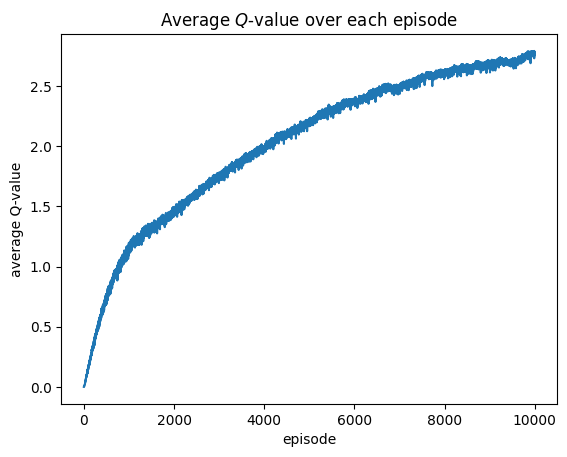

In [21]:
plt.plot(average_episode_Q_values_list)
plt.title('Average $Q$-value over each episode')
plt.xlabel('episode')
plt.ylabel('average Q-value')
plt.show()

The least number of sum of buys and sells

In [22]:
np.min(sum_buy_sell_list).item()

56

**Sum of Buy and Sell Actions in OU Process Distribution:**

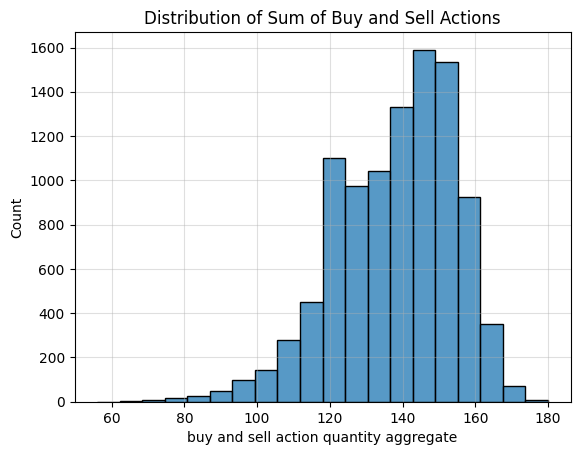

In [23]:
sns.histplot(sum_buy_sell_list, bins=20)
plt.title('Distribution of Sum of Buy and Sell Actions')
plt.xlabel('buy and sell action quantity aggregate')
plt.grid(alpha=0.4)
plt.show()

**Evaluation**

First, the performance of the trained agent on a simulated path of OU process is measured

In [24]:
rng = np.random.RandomState(58)

sim_data = OU_simulation(mu=1, theta=theta, sigma=0.1, delta_time=1, n_sims=1, T=T, random_state=rng)[0]
states = create_states(sim_data, lookback_len=lookback_window, k=0.03)

# track action taken at each step
actions_list_testing = []

position = 0

for t in range(len(sim_data)):

  # find index of Q-values of state
  state_in_Q_table = find_state_in_Q_table(states[t])

  # find Q-values
  Q_values = Q_table[state_in_Q_table].copy()

  # rule out invalid actions
  # always greedy in testing
  if position == 0:
    Q_values[0] = - float('inf')
  elif position == 1:
    Q_values[2] = - float('inf')

  # index of highest valid Q-value
  action_index = np.argmax(Q_values).item()


  # finding the action
  if action_index == 0:
    action = -1
  elif action_index == 1:
    action = 0
  elif action_index == 2:
    action = 1

  # updating position
  if (action == -1):
    position -= 1
  if (action == 1):
    position += 1

  actions_list_testing.append(action)

print(f"\nNumber of Sells: {np.sum(np.array(actions_list_testing) == -1)}")
print(f"Number of Holds: {np.sum(np.array(actions_list_testing) == 0)}")
print(f"Number of Buys: {np.sum(np.array(actions_list_testing) == 1)}\n")


Number of Sells: 84
Number of Holds: 84
Number of Buys: 84



In [25]:
actions_list_np = np.array(actions_list_testing)
buys = np.argwhere(actions_list_np == 1).flatten()
sells = np.argwhere(actions_list_np == -1).flatten()

**Compute PnL**

In [26]:
pnl = 0
pnl_list = []
for i in range(min(len(buys), len(sells))):
  pnl += sim_data[sells[i]] - sim_data[buys[i]]
  pnl_list.append(pnl)
print(f"The final PnL is: {pnl}")

The final PnL is: 7.299512026900363


**PnL change over the single simulation**

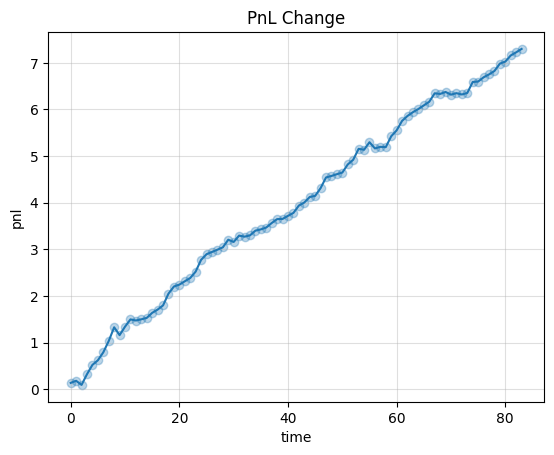

In [27]:
plt.plot(pnl_list)
plt.scatter(range(len(pnl_list)), pnl_list, alpha=0.3)
plt.title("PnL Change")
plt.xlabel("time")
plt.ylabel("pnl")
plt.grid(alpha=0.4)
plt.show()

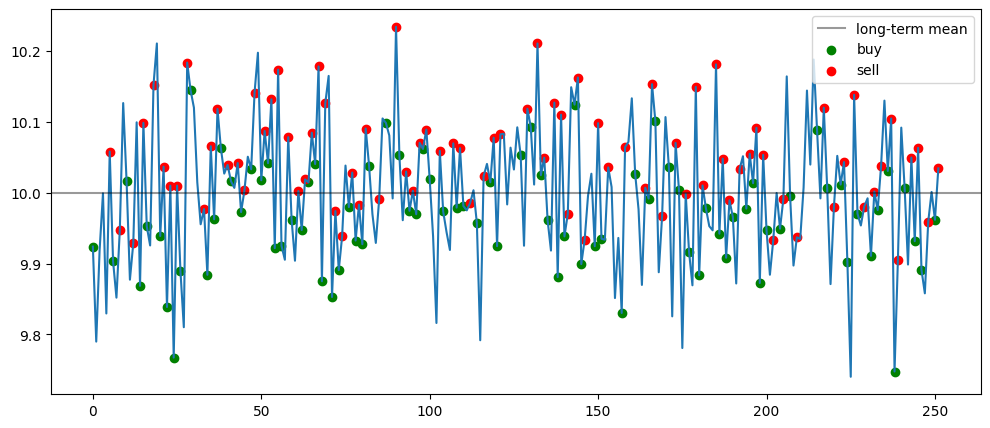

In [28]:
plt.figure(figsize=(12, 5))
plt.plot(sim_data)
plt.axhline(theta, color='black', alpha=0.4, label='long-term mean')
plt.scatter(buys, sim_data[buys], color='green', label='buy')
plt.scatter(sells, sim_data[sells], color='red', label='sell')
plt.legend()
plt.show()

**Percentage of buy and sell actions below and above mean**

Agent chose the buy action below the long-term mean with the accuracy of 71.8%. For sell actions, 74.6% of of the actions were above the long-term mean.

In [29]:
buys_below_mean = round(np.sum(sim_data[buys] < theta).item() / len(sim_data[buys]) * 100, 3)
sells_above_mean = round(np.sum(sim_data[sells] > theta).item() / len(sim_data[sells]) * 100, 3)

print(f"Percentage of buy actions below mean: {buys_below_mean}")
print(f"Percentage of sell actions above mean: {sells_above_mean}")

Percentage of buy actions below mean: 65.476
Percentage of sell actions above mean: 76.19


**Sharpe ratio over simulated OU data:**

In [30]:
last_pnl = pnl_list[-1]
first_pnl = pnl_list[0]
variance = np.std(pnl_list)

sharpe = (last_pnl - first_pnl)/variance

print(f"Sharpe ratio on simulated data: {round(sharpe, 2)}")

Sharpe ratio on simulated data: 3.48


# **Evaluation**

This section (trading phase) evaluates the performance of the trained $Q$-learning agent on the spread value between tickers **GOOGL** and **MSFT** with the optimized coefficient $B$ that is previously computed through grid search.

**Testing on cointegrated instruments:**

The optimal value for coefficient $B$ between **GOOGL** and **MSFT** tickers from **23-01-01** to **23-12-31** using the important extrema finder algorithm is **0.73**. Therefore, this value will be used as cointegration coefficient starting from **24-01-01** to **24-12-31** which is the test set.

In [31]:
dat = yf.Tickers('GOOGL MSFT')
googl = dat.tickers['GOOGL'].history(start='2024-01-01', end='2024-12-31')
msft = dat.tickers['MSFT'].history(start='2024-01-01', end='2024-12-31')

In [32]:
googl_np = np.array(googl['Close'].tolist())
msft_np = np.array(msft['Close'].tolist())

In [33]:
spread = googl_np - googl_msft_B * msft_np

**Creating states from raw spread data**

In [34]:
spread_states = create_states(spread, lookback_len=lookback_window, k=0.03)

In [35]:
actions_list_testing = []

position = 0

for t in range(len(spread)):

  # find index of Q-values of state
  state_in_Q_table = find_state_in_Q_table(spread_states[t])

  # find Q-values
  Q_values = Q_table[state_in_Q_table].copy()

  # rule out invalid actions
  # always greedy in testing
  if position == 0:
    Q_values[0] = - float('inf')
  elif position == 1:
    Q_values[2] = - float('inf')

  # index of highest valid Q-value
  action_index = np.argmax(Q_values).item()


  # finding the action
  if action_index == 0:
    action = -1
  elif action_index == 1:
    action = 0
  elif action_index == 2:
    action = 1

  # updating position
  if (action == -1):
    position -= 1
  if (action == 1):
    position += 1

  actions_list_testing.append(action)

print(f"\nNumber of Sells: {np.sum(np.array(actions_list_testing) == -1)}")
print(f"Number of Holds: {np.sum(np.array(actions_list_testing) == 0)}")
print(f"Number of Buys: {np.sum(np.array(actions_list_testing) == 1)}\n")


Number of Sells: 60
Number of Holds: 131
Number of Buys: 60



In [36]:
actions_list_np = np.array(actions_list_testing)
buys = np.argwhere(actions_list_np == 1).flatten()
sells = np.argwhere(actions_list_np == -1).flatten()

**Tracking PnL Change:**

For PnL change, it is important to understand when and on which asset to go long or short. For spread with formula:

$$X = ∑_{i=1}^{n}a_i S_i$$

• If the action is buy, we long the assets with positive coefficients and short the assets with negative coefficients.

• On the other hand, if the action is sell, we short the assests with positive coefficients and long the assets with negative coefficients.

In [68]:
pnl = 0
pnl_list = []
for i in range(min(len(buys), len(sells)) -1 ):
  pnl += googl_np[sells[i]] - googl_np[buys[i]]
  pnl += msft_np[buys[i+1]] - msft_np[sells[i]]
  pnl_list.append(pnl.item())

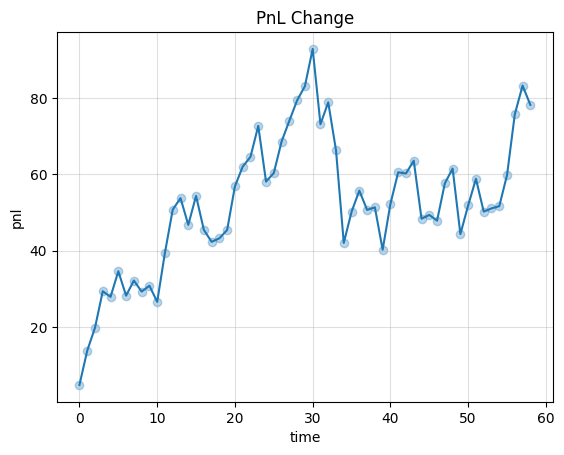

In [75]:
plt.plot(pnl_list)
plt.scatter(range(len(pnl_list)), pnl_list, alpha=0.3)
plt.title("PnL Change")
plt.xlabel("time")
plt.ylabel("pnl")
plt.grid(alpha=0.4)
plt.show()

In [76]:
last_pnl = pnl_list[-1]
first_pnl = pnl_list[0]
variance = np.std(pnl_list)

sharpe = (last_pnl - first_pnl)/variance

print(f"Sharpe ratio on simulated data: {sharpe}")

Sharpe ratio on simulated data: 4.137118445233324


# **Conclusion**


In conclusion, the statistical arbitrage strategy using reinforcement learning creates an agent which leads to positive returns on both the simulated test data and out-of-sample market data ,achieving high Sharpe ratio of 4.13

For future research, instead of using $Q$-learning with $Q$-tables, actor-critic agents with deep neural networks (DNN) which are proven to be superior to traditional reinforcment learning approaches will be employed for the decision-making task. Their ability to receive continuous state-space means the agent can learn more granular dynamics of the environment and make more profitable decisions.